In [2]:
# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# System and Random Utilities
import os
import random

from pathlib import Path
import warnings

from tqdm import tqdm
from IPython.display import clear_output

# import lightning.pytorch as pl
# from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
# from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb

# Time-Series Analysis Libraries
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



# from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
# from pytorch_forecasting.data import GroupNormalizer
# from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [3]:
# Set the seed for reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Set seed for random module
random.seed(seed_value)

# Set seed for numpy module
np.random.seed(seed_value)

# # Set seed for TensorFlow
# tf.random.set_seed(seed_value)

In [4]:
df = pd.read_csv('../datasets/train.csv')
print(df.shape)
df.head()

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
df['date'] = pd.to_datetime(df['date'])

df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

df['weekday'] = df['date'].dt.day_name()
df

,date,store,item,sales,day,month,year,weekday
0,2013-01-01,1,1,13,1,1,2013,Tuesday
1,2013-01-02,1,1,11,2,1,2013,Wednesday
2,2013-01-03,1,1,14,3,1,2013,Thursday
3,2013-01-04,1,1,13,4,1,2013,Friday
4,2013-01-05,1,1,10,5,1,2013,Saturday
...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,27,12,2017,Wednesday
912996,2017-12-28,10,50,59,28,12,2017,Thursday
912997,2017-12-29,10,50,74,29,12,2017,Friday
912998,2017-12-30,10,50,62,30,12,2017,Saturday


In [6]:
start_date = pd.to_datetime('2013-01-01', format='%Y-%m-%d')
df['time_idx'] = (df['date'] - start_date).dt.days + 1
df

,date,store,item,sales,day,month,year,weekday,time_idx
0,2013-01-01,1,1,13,1,1,2013,Tuesday,1
1,2013-01-02,1,1,11,2,1,2013,Wednesday,2
2,2013-01-03,1,1,14,3,1,2013,Thursday,3
3,2013-01-04,1,1,13,4,1,2013,Friday,4
4,2013-01-05,1,1,10,5,1,2013,Saturday,5
...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,27,12,2017,Wednesday,1822
912996,2017-12-28,10,50,59,28,12,2017,Thursday,1823
912997,2017-12-29,10,50,74,29,12,2017,Friday,1824
912998,2017-12-30,10,50,62,30,12,2017,Saturday,1825


In [7]:
df_month = df.groupby(['store', 'item', 'year', 'month'])['sales'].sum().reset_index()

df_month['date'] = pd.to_datetime(df_month['year'].astype(str) + '-' + df_month['month'].astype(str), format='%Y-%m').dt.to_period('M')

start_date = pd.to_datetime('2013-01', format='%Y-%m')
df_month['time_idx'] = (df_month['date'].dt.year * 12 + df_month['date'].dt.month) - (start_date.year * 12 + start_date.month) + 1

# df_month[['store',	'item']] = df_month[['store',	'item']].astype(str)
df_month

,store,item,year,month,sales,date,time_idx
0,1,1,2013,1,328,2013-01,1
1,1,1,2013,2,322,2013-02,2
2,1,1,2013,3,477,2013-03,3
3,1,1,2013,4,522,2013-04,4
4,1,1,2013,5,531,2013-05,5
...,...,...,...,...,...,...,...
29995,10,50,2017,8,2867,2017-08,56
29996,10,50,2017,9,2586,2017-09,57
29997,10,50,2017,10,2507,2017-10,58
29998,10,50,2017,11,2574,2017-11,59


In [8]:
# df_month[:24]
# df_month[24:36]

In [9]:
def pretrain_df(df_month):
    df_pretrain = df_month.copy()

    df_pretrain = pd.get_dummies(df_pretrain, columns=['month'], prefix='month')
    df_pretrain = pd.get_dummies(df_pretrain, columns=['year'], prefix='year')

    df_pretrain[df_pretrain.select_dtypes(include=bool).columns] = df_pretrain.select_dtypes(include=bool).astype(int)
    df_pretrain.drop(columns=['store', 'item', 'date'], inplace=True)

    # Create lag features for time-series modeling
    num_lags = 12 
    for i in range(1, num_lags + 1):
        df_pretrain[f'nb_order_lag_{i}'] = df_pretrain['sales'].shift(i)

    df_pretrain = df_pretrain.dropna()
    return df_pretrain

def train_test_split(df_pretrain):
    # Separating target variable 'nb_order' and features
    y = df_pretrain['sales']
    X = df_pretrain.drop(columns='sales')

    # Scaling features and combining with the target variable
    df_scaled = pd.DataFrame(np.column_stack([y, X]), columns=['sales'] + X.columns.tolist())

    # Split the data into train and test sets
    train_size = int(len(df_scaled)-12)  # Test set is 12 months
    train, test = df_scaled[:train_size], df_scaled[train_size:]

    return train, test

def train_model(X_train, y_train):
    # Set hyperparameters
    model = lgb.LGBMRegressor(
    force_col_wise=True,
    learning_rate=0.1,
    n_estimators=100,
    min_data_in_leaf = 0
    )

    model.fit(X_train, y_train)
    return model

def forecast(model, X_test):
    # Initialize an empty list to store forecasted values
    forecast_values = []

    # Initialize the current sequence with the first row of the test set
    current_sequence = X_test[0:1]

    # Loop to predict the next 72 hours 
    for _ in range(12):
        # Predict the next hour's value using the trained model
        next_hour_pred = model.predict(current_sequence)
        
        # Append the prediction to the forecast values
        forecast_values.append(next_hour_pred[0])


        next_month_pred = model.predict(current_sequence)
        time_idx = current_sequence[0][0] + 1
        month_seq = current_sequence[0][1:13] 
        year_seq = current_sequence[0][13:18]

        # Check if the last element of order_hour is 1 and swap values if true
        if month_seq[-1] == 1:
            month_seq[0], month_seq[-1] = 1, 0
        else:
            month_seq = np.roll(month_seq, 1)

        current_sequence_lag = current_sequence[0][18:]
        current_sequence_lag = np.roll(current_sequence_lag, 1)
        current_sequence_lag[0] = next_month_pred[0]

        current_sequence = [np.concatenate(([time_idx], month_seq, year_seq, current_sequence_lag))]
        
    return forecast_values

def compare_true(df_store_item, prediction):
    baseline = df_store_item[36:48]['sales'].mean()
    df_impact = df_store_item[48:].copy()
    df_impact['pred'] = prediction
    ss = df_store_item[36:48]['sales'].max() - df_store_item[36:48]['sales'].mean()

    stock_baseline = 0
    stock_pred = 0
    lst_baseline, lst_pred = [], []
    print(baseline)
    for month in range(12):
        if stock_baseline <= baseline:
            stock_baseline = baseline + (ss *0.23)
            # stock_baseline = baseline 

        if stock_pred <= prediction[month]:
            stock_pred = prediction[month] * 1.05
        
        stock_baseline -= df_impact['sales'].iloc[month]
        stock_pred -= df_impact['sales'].iloc[month]
        # if stock_baseline < 0:
        #     stock_baseline = 0
        # if stock_pred < 0:
        #     stock_pred = 0
        lst_baseline.append(stock_baseline)
        lst_pred.append(stock_pred)
            
    df_impact['stock_pred'] = lst_pred
    df_impact['stock_baseline'] = lst_baseline
    df_impact['diff_pred%'] = df_impact['stock_pred'] /  df_impact['sales'] * 100
    df_impact['diff_base%'] = df_impact['stock_baseline'] / df_impact['sales'] * 100

    return df_impact

def compare_true(df_store_item, prediction):
    min_stock = df_store_item[36:48]['sales'].mean()
    max_stock = min_stock * 1.05
    df_impact = df_store_item[48:].copy()
    df_impact['pred'] = prediction

    stock_baseline = 0
    stock_pred = 0
    lst_baseline, lst_pred = [], []
    # print(baseline)
    for month in range(12):
        if stock_baseline <= min_stock:
            stock_baseline = max_stock
            # stock_baseline = baseline 

        if stock_pred <= prediction[month]:
            stock_pred = prediction[month] * 1.05
        
        stock_baseline -= df_impact['sales'].iloc[month]
        stock_pred -= df_impact['sales'].iloc[month]
        lst_baseline.append(stock_baseline)
        lst_pred.append(stock_pred)
            
    df_impact['stock_pred'] = lst_pred
    df_impact['stock_baseline'] = lst_baseline
    df_impact['diff_pred%'] = df_impact['stock_pred'] /  df_impact['sales'] * 100
    df_impact['diff_base%'] = df_impact['stock_baseline'] / df_impact['sales'] * 100

    return df_impact

In [11]:
dfs_impact = pd.DataFrame()
for store in tqdm(range(1, 11)):
    for item in range(1,51):
        df_store_item = df_month[(df_month['store']==store) &(df_month['item']==item)]
        df_pretrain = pretrain_df(df_store_item )

        train, test = train_test_split(df_pretrain)
        X_train, y_train = train.drop(columns='sales').values, train['sales'].values
        X_test, y_test = test.drop(columns='sales').values, test['sales'].values

        model = train_model(X_train, y_train)
        prediction = forecast(model, X_test)

        df_impact = compare_true(df_store_item , prediction)
        dfs_impact = pd.concat([dfs_impact, df_impact], ignore_index=True)

        clear_output(wait=True)

In [12]:
dfs_impact = pd.DataFrame()
for store in tqdm(range(1, 2)):
    for item in range(1,2):
        df_store_item = df_month[(df_month['store']==store) &(df_month['item']==item)]
        df_pretrain = pretrain_df(df_store_item )

        train, test = train_test_split(df_pretrain)
        X_train, y_train = train.drop(columns='sales').values, train['sales'].values
        X_test, y_test = test.drop(columns='sales').values, test['sales'].values

        model = train_model(X_train, y_train)
        prediction = forecast(model, X_test)

        df_impact = compare_true(df_store_item , prediction)
        dfs_impact = pd.concat([dfs_impact, df_impact], ignore_index=True)

        clear_output(wait=True)

100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


In [ ]:
dfs_impact['diff_pred%'].describe()
dfs_impact

,store,item,year,month,sales,date,time_idx,pred,stock_pred,stock_baseline,diff_pred%,diff_base%
0,1,1,2017,1,485,2017-01,49,496.002452,35.802574,210.6250,7.381974,43.427835
1,1,1,2017,2,487,2017-02,50,496.002452,33.802574,208.6250,6.940980,42.838809
2,1,1,2017,3,561,2017-03,51,613.406660,83.076993,134.6250,14.808733,23.997326
3,1,1,2017,4,677,2017-04,52,684.617590,41.848469,18.6250,6.181458,2.751108
4,1,1,2017,5,773,2017-05,53,781.995832,48.095624,-77.3750,6.221944,-10.009702
...,...,...,...,...,...,...,...,...,...,...,...,...
115,10,1,2017,8,945,2017-08,56,848.998092,-53.552004,-76.5625,-5.666879,-8.101852
116,10,1,2017,9,865,2017-09,57,848.998092,26.447996,3.4375,3.057572,0.397399
117,10,1,2017,10,861,2017-10,58,853.702656,35.387789,7.4375,4.110080,0.863821
118,10,1,2017,11,860,2017-11,59,853.997611,36.697492,8.4375,4.267150,0.981105


In [ ]:
pred_out_stock = dfs_impact[dfs_impact['diff_pred%'] < 0]
pred_dead_stock = dfs_impact[dfs_impact['diff_pred%'] > 0]
base_out_stock = dfs_impact[dfs_impact['diff_base%'] < 0]
base_dead_stock = dfs_impact[dfs_impact['diff_base%'] > 0] 

print(dfs_impact['diff_pred%'].abs().sum() / 500)
print(dfs_impact['diff_base%'].abs().sum() / 500)

print('model out of stock:',pred_out_stock['diff_pred%'].abs().sum() / 500 / 12)
print('model deadstock:',pred_dead_stock['diff_pred%'].abs().sum() / 500 / 12)
print('baseline out of stock:',base_out_stock['diff_base%'].abs().sum() / 500 / 12)
print('baseline deadstock:',base_dead_stock['diff_base%'].abs().sum() / 500 / 12)

2.471774334440595
4.125212859655401
model out of stock: 0.04558349065626966
model deadstock: 0.16039770388044658
baseline out of stock: 0.11442911711561203
baseline deadstock: 0.22933862118900475


In [ ]:
pred_out_stock = dfs_impact[dfs_impact['diff_pred%'] < 0]
pred_dead_stock = dfs_impact[dfs_impact['diff_pred%'] > 0]
base_out_stock = dfs_impact[dfs_impact['diff_base%'] < 0]
base_dead_stock = dfs_impact[dfs_impact['diff_base%'] > 0] 

print(dfs_impact['diff_pred%'].abs().sum() / 500)
print(dfs_impact['diff_base%'].abs().sum() / 500)

print('model out of stock:',pred_out_stock['diff_pred%'].abs().sum() / 500 / 12)
print('model deadstock:',pred_dead_stock['diff_pred%'].abs().sum() / 500 / 12)
print('baseline out of stock:',base_out_stock['diff_base%'].abs().sum() / 500 / 12)
print('baseline deadstock:',base_dead_stock['diff_base%'].abs().sum() / 500 / 12)

128.0547472650587
209.33323128564805
model out of stock: 0.8603469116434149
model deadstock: 9.810882027111475
baseline out of stock: 4.779099029751792
baseline deadstock: 12.665336910718878


In [ ]:
pred_out_stock = dfs_impact[dfs_impact['diff_pred%'] < 0]
pred_dead_stock = dfs_impact[dfs_impact['diff_pred%'] > 0]
base_out_stock = dfs_impact[dfs_impact['diff_base%'] < 0]
base_dead_stock = dfs_impact[dfs_impact['diff_base%'] > 0] 

print(dfs_impact['diff_pred%'].abs().sum() / 500)
print(dfs_impact['diff_base%'].abs().sum() / 500)

print('model out of stock:',pred_out_stock['diff_pred%'].abs().sum() / 500 / 12)
print('model deadstock:',pred_dead_stock['diff_pred%'].abs().sum() / 500 / 12)
print('baseline out of stock:',base_out_stock['diff_base%'].abs().sum() / 500 / 12)
print('baseline deadstock:',base_dead_stock['diff_base%'].abs().sum() / 500 / 12)

128.0547472650587
210.9798205274705
model out of stock: 0.8603469116434149
model deadstock: 9.810882027111475
baseline out of stock: 8.538183884248319
baseline deadstock: 9.04346782637422


In [ ]:
pred_out_stock = dfs_impact[dfs_impact['diff_pred%'] < 0]
pred_dead_stock = dfs_impact[dfs_impact['diff_pred%'] > 0]
base_out_stock = dfs_impact[dfs_impact['diff_base%'] < 0]
base_dead_stock = dfs_impact[dfs_impact['diff_base%'] > 0] 

print(dfs_impact['diff_pred%'].abs().sum() / 500)
print(dfs_impact['diff_base%'].abs().sum() / 500)

print('model out of stock:',pred_out_stock['diff_pred%'].abs().sum() / 500 / 12)
print('model deadstock:',pred_dead_stock['diff_pred%'].abs().sum() / 500 / 12)
print('baseline out of stock:',base_out_stock['diff_base%'].abs().sum() / 500 / 12)
print('baseline deadstock:',base_dead_stock['diff_base%'].abs().sum() / 500 / 12)

113.92065019801218
209.33323128564805
model out of stock: 1.3090503444733168
model deadstock: 8.184337172027698
baseline out of stock: 4.779099029751792
baseline deadstock: 12.665336910718878


In [ ]:
pred_dead_stock['diff_pred%'].describe()

count    4788.000000
mean       12.294338
std         9.291384
min         0.001633
25%         4.888696
50%        11.091804
75%        16.787165
max        69.773765
Name: diff_pred%, dtype: float64

In [40]:
# # Function to plot actual vs. predicted values
# def plot_impact(testing_hours, y_test, prediction, baseline):
#   df_test = pd.DataFrame({"hour": testing_hours, "actual": y_test, "prediction": prediction })

#   # df_test = pd.DataFrame({"hour": testing_hours, "actual": y_test, "prediction": prediction , "baseline2": baseline2})
#   figure, ax = plt.subplots(figsize=(10, 5))
#   df_test.plot(ax=ax, label="Actual", x="hour", y="actual")
#   df_test.plot(ax=ax, label="Prediction", x="hour", y="prediction")
#   # df_test.plot(ax=ax, label="Baseline2", x="hour", y="baseline2")

#   plt.title("Actual vs. Predicted")
#   plt.xlabel("Month of year")
#   plt.ylabel("Number of Orders")
#   plt.axhline(y=baseline, color='r', linestyle='--', label='Basedline stock')

#   plt.legend()

#   plt.show()

# Function to plot actual vs. predicted values
def plot_impact(month, y_test, prediction, baseline, ss):
  df_test = pd.DataFrame({"month": month, "actual": y_test, "prediction":  prediction - y_test, "jenny": (baseline*1.05) - y_test})

  figure, ax = plt.subplots(figsize=(10, 5))
  # df_test.plot(ax=ax, label="Actual order", x="month", y="actual")
  df_test.plot(ax=ax, label="Jenny stock - actual order", x="month", y="jenny")
  df_test.plot(ax=ax, label="Predicted stock - actual order", x="month", y="prediction")

  plt.title("Jenny compare to Predicted")
  plt.xlabel("Month of year")
  plt.ylabel("Number of Orders")
  plt.axhline(y=0, color='r', linestyle='--', label='Stock fits the order')

  plt.legend()
  # Set the background color to transparent
  ax.patch.set_facecolor('none')
  ax.patch.set_alpha(0) 
  plt.savefig('.',transparent=True)
  plt.show()

# Function to plot actual vs. predicted values
def plot_impact_baseline(month, sales, prediction, baseline, ss, ideal):
  df_test = pd.DataFrame({"month": month, "actual": sales, "prediction":  prediction , "jenny": baseline})

  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Jenny's inventory", x="month", y="jenny")
  # df_test.plot(ax=ax, label="Predicted stock - actual order", x="month", y="prediction")

  plt.title("Jenny's inventory health")
  plt.xlabel("day of year")
  plt.ylabel("Inventory")
  plt.axhline(y=ideal, color='orange', linestyle='--', label='Ideal inventory')
  plt.axhline(y=ss, color='g', linestyle='--', label='Safety stock')
  plt.axhline(y=0, color='r', linestyle='--', label='Out of stock')

  plt.legend()
  # Set the background color to transparent
  ax.patch.set_facecolor('none')
  ax.patch.set_alpha(0) 
  plt.savefig('.',transparent=True)
  plt.show()

def plot_impact_pred(month, sales, prediction, baseline, ss, ideal):
  df_test = pd.DataFrame({"month": month, "actual": sales, "prediction":  prediction / 1.3 , "jenny": baseline})

  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Jenny's inventory", x="month", y="jenny")
  df_test.plot(ax=ax, label="Predicted inventory", x="month", y="prediction")

  plt.title("VMI add-ons inventory health")
  plt.xlabel("day of year")
  plt.ylabel("Inventory")
  plt.axhline(y=ideal, color='orange', linestyle='--', label='Ideal inventory')
  plt.axhline(y=ss, color='g', linestyle='--', label='Safety stock')
  plt.axhline(y=0, color='r', linestyle='--', label='Out of stock')

  plt.legend()
  # Set the background color to transparent
  ax.patch.set_facecolor('none')
  ax.patch.set_alpha(0) 
  plt.savefig('.',transparent=True)
  plt.show()

In [25]:
df_plot = df[(df['store']==1) & (df['item']==1)][1461:]
df_plot['stock_pred'] = 0
df_plot['stock_baseline'] = 0
baseline = df_store_item[36:48]['sales'].mean()

month = 1
for i in(range(len(df_plot))):
    if df_plot['day'].iloc[i] == 1:
        df_plot['stock_pred'].iloc[i] = prediction[month-1] * 1.05
        df_plot['stock_baseline'].iloc[i] = baseline * 1.05
        month += 1
    else:
        df_plot['stock_pred'].iloc[i] = df_plot['stock_pred'].iloc[i-1]
        df_plot['stock_baseline'].iloc[i] = df_plot['stock_baseline'].iloc[i-1]

    df_plot['stock_pred'].iloc[i] -= df_plot['sales'].iloc[i]
    # if df_plot['stock_pred'].iloc[i] <= 0:
    #     df_plot['stock_pred'].iloc[i] = 0

    df_plot['stock_baseline'].iloc[i] -= df_plot['sales'].iloc[i]
    # if df_plot['stock_baseline'].iloc[i] <= 0:
    #     df_plot['stock_baseline'].iloc[i] = 0

df_plot

,date,store,item,sales,day,month,year,weekday,time_idx,stock_pred,stock_baseline
1461,2017-01-01,1,1,19,1,1,2017,Sunday,1462,477.002452,676.625
1462,2017-01-02,1,1,15,2,1,2017,Monday,1463,462.002452,661.625
1463,2017-01-03,1,1,10,3,1,2017,Tuesday,1464,452.002452,651.625
1464,2017-01-04,1,1,16,4,1,2017,Wednesday,1465,436.002452,635.625
1465,2017-01-05,1,1,14,5,1,2017,Thursday,1466,422.002452,621.625
...,...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,27,12,2017,Wednesday,1822,47.003313,246.625
1822,2017-12-28,1,1,19,28,12,2017,Thursday,1823,28.003313,227.625
1823,2017-12-29,1,1,15,29,12,2017,Friday,1824,13.003313,212.625
1824,2017-12-30,1,1,27,30,12,2017,Saturday,1825,-13.996687,185.625


In [15]:
ideal = 0
for i in range(12):
    # ideal += df_plot[df_plot['month'] == i+1]['sales'].max()
    ideal += df_plot[df_plot['month'] == i+1]['sales'].sum()
ideal = ideal /12 
ideal

674.75

In [16]:
df_store_item[:]['sales'].max() 

903

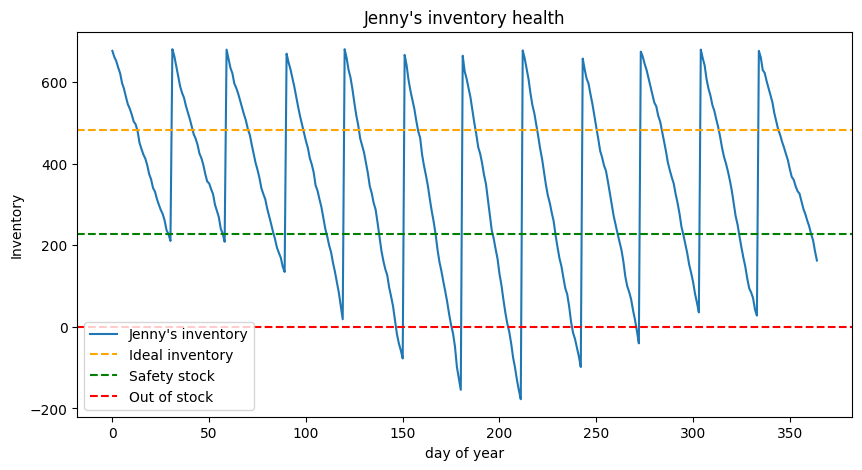

In [23]:
baseline = df_store_item[36:48]['sales'].mean()
ideal = df_store_item['sales'].max() / 28 * 15
avg = sum(prediction) / len(prediction)
ss = max(prediction) - avg 

plot_impact_baseline(range(365), df_plot['sales'], df_plot['stock_pred'], df_plot['stock_baseline'], ss, ideal)

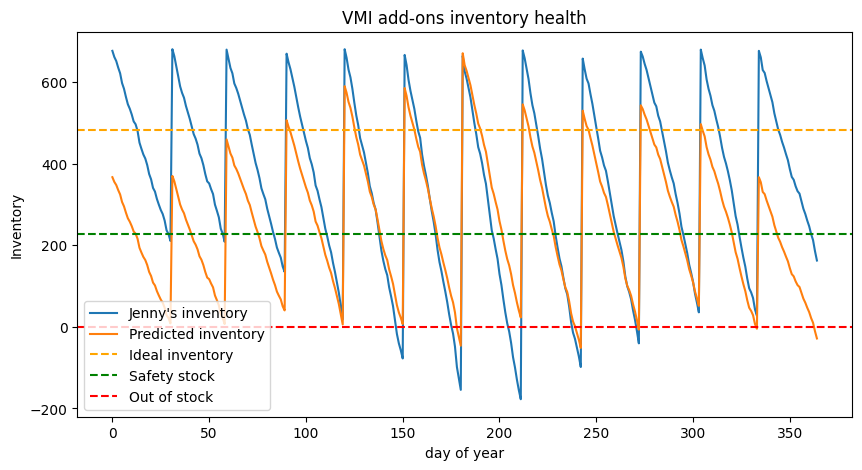

In [41]:
plot_impact_pred(range(365), df_plot['sales'], df_plot['stock_pred'], df_plot['stock_baseline'], ss, ideal)

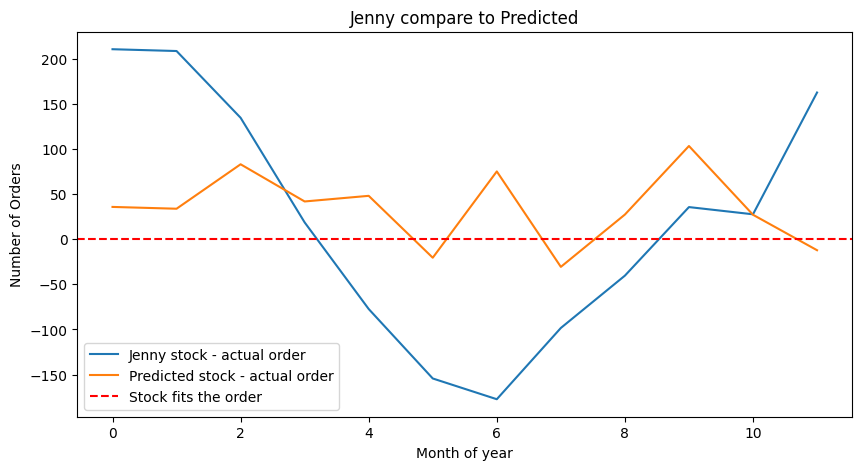

In [101]:
baseline = df_store_item[36:48]['sales'].mean()
avg = sum(prediction) / len(prediction)
ss = max(prediction) - avg 

plot_impact(range(12), y_test, [i * 1.05 for i in prediction], baseline, ss)

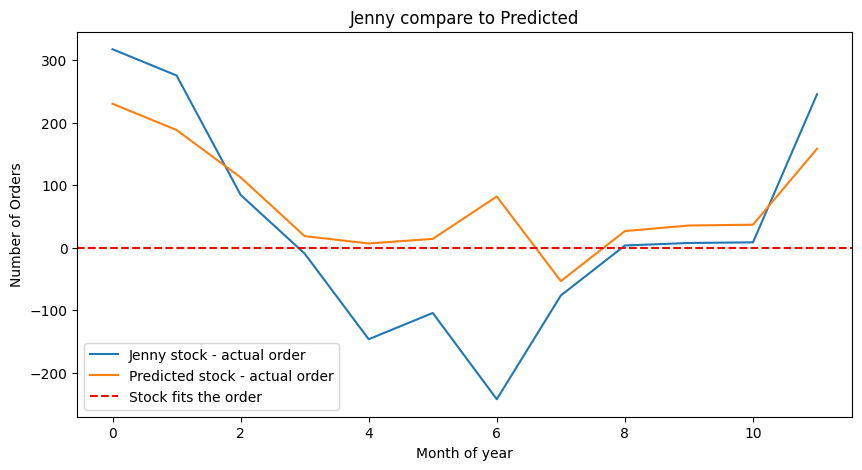

In [15]:
baseline = df_store_item[36:48]['sales'].mean()
avg = sum(prediction) / len(prediction)
ss = max(prediction) - avg

plot_impact(range(12), y_test, [i * 1.05 for i in prediction], baseline, ss)

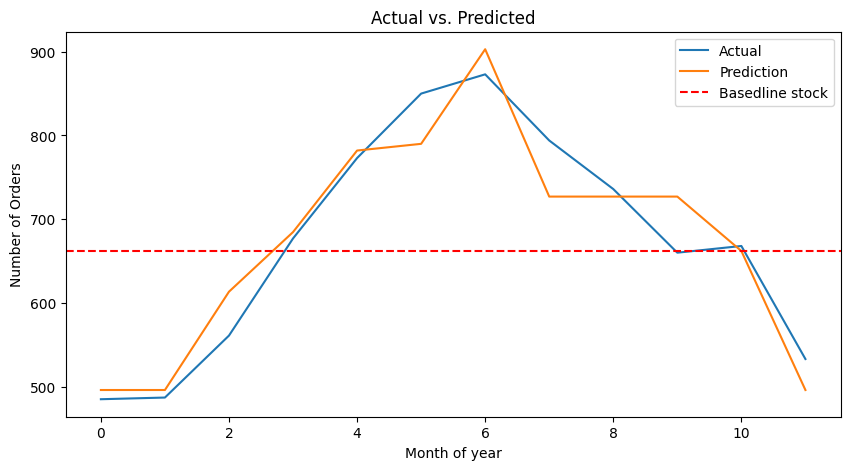

In [14]:
baseline = df_store_item[36:48]['sales'].mean()
plot_impact(range(12), y_test, prediction, baseline)

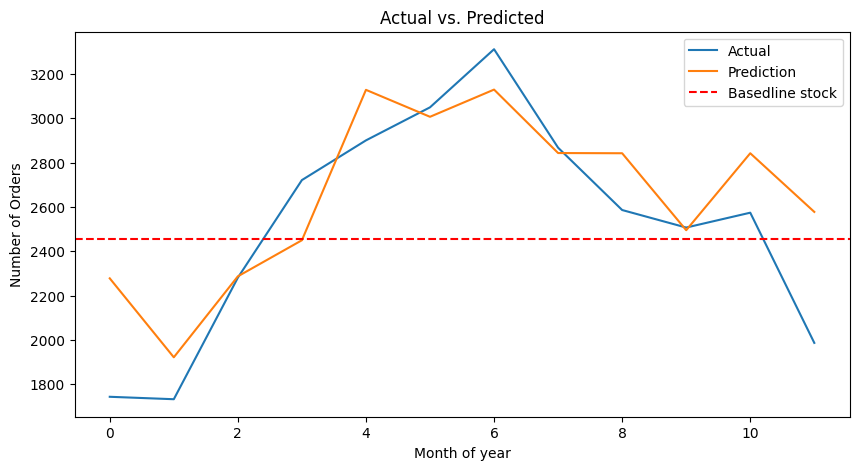

In [260]:
baseline = df_store_item[36:48]['sales'].mean()
plot_impact(range(12), y_test, prediction, baseline)

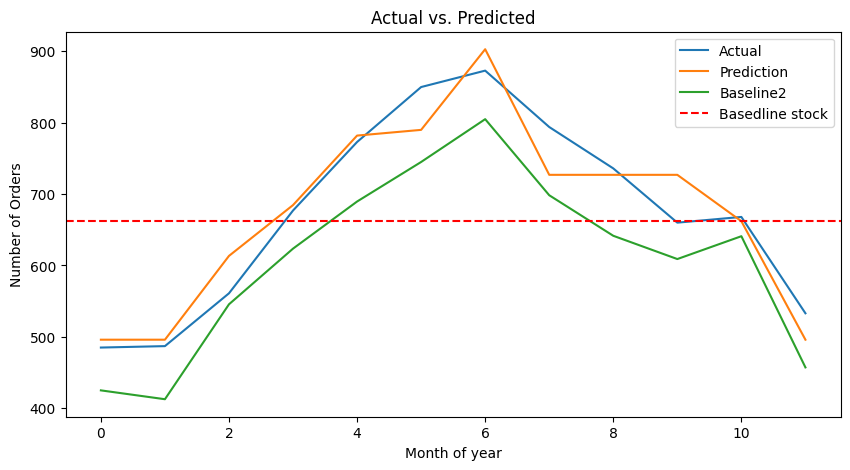

In [58]:
baseline = df_month[36:48]['sales'].mean()
lst_base = []
for i in range(1,13):
    df_base = df_month[df_month['month']==i]
    lst_base.append(df_base['sales'].mean())
plot_impact(range(12), y_test, prediction, baseline, lst_base)

In [49]:
df_impact = df_month[48:].copy()
df_impact['pred'] = prediction
df_impact['baseline'] = baseline
df_impact['baseline2'] = lst_base

df_impact['diff_pred'] = df_impact['sales'] - df_impact['pred']
df_impact['diff_base'] = df_impact['sales'] - df_impact['baseline'] 
df_impact['diff_base2'] = df_impact['sales'] - df_impact['baseline2'] 

df_impact

,store,item,year,month,sales,date,time_idx,pred,baseline,baseline2,diff_pred,diff_base,diff_base2
48,1,1,2017,1,485,2017-01,49,496.002452,662.500000,425.000000,-11.002452,-177.500000,60.000000
49,1,1,2017,2,487,2017-02,50,496.002452,662.500000,412.600000,-9.002452,-175.500000,74.400000
50,1,1,2017,3,561,2017-03,51,613.406660,662.500000,545.600000,-52.406660,-101.500000,15.400000
51,1,1,2017,4,677,2017-04,52,684.617590,662.500000,623.600000,-7.617590,14.500000,53.400000
52,1,1,2017,5,773,2017-05,53,781.995832,662.500000,689.600000,-8.995832,110.500000,83.400000
53,1,1,2017,6,850,2017-06,54,789.995388,662.500000,745.000000,60.004612,187.500000,105.000000
54,1,1,2017,7,873,2017-07,55,902.992502,662.500000,805.000000,-29.992502,210.500000,68.000000
55,1,1,2017,8,794,2017-08,56,726.997177,662.500000,698.400000,67.002823,131.500000,95.600000
56,1,1,2017,9,736,2017-09,57,726.997177,662.500000,641.600000,9.002823,73.500000,94.400000
57,1,1,2017,10,660,2017-10,58,726.997177,662.500000,609.000000,-66.997177,-2.500000,51.000000


In [50]:
print(df_impact['diff_pred'].abs().sum())
print(df_impact['diff_base'].abs().sum())
print(df_impact['diff_base2'].abs().sum())

365.02270567738634
1320.0
803.3999999999999
